# Stacked auto-encoders and fully-connected networks 

A deep regression model and hyperspectral imaging for rapid detection of nitrogen concentration in potato leaf, using Stacked auto-encoders (SAE) and fully-connected networks (FNN)

In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Import MNIST data
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

headers = ["699nm","713nm","726nm","739nm","752nm","766nm","780nm","794nm","807nm","821nm","834nm","847nm",
           "859nm","872nm","884nm","896nm","908nm","919nm","930nm","941nm","952nm","962nm","972nm","982nm",
           "992nm","total Nitrogen perc"]

# data
data = pd.read_csv('../../../data/final_data_table_20_avg.csv')
#data = pd.read_csv('../../../data/final_data_table_single_avg.csv') 

data = data[headers] 

data.head()

split = int(data.shape[0]*3/4)


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .v

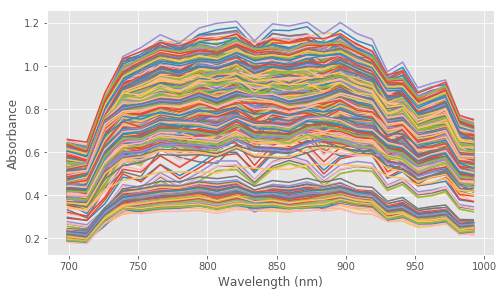

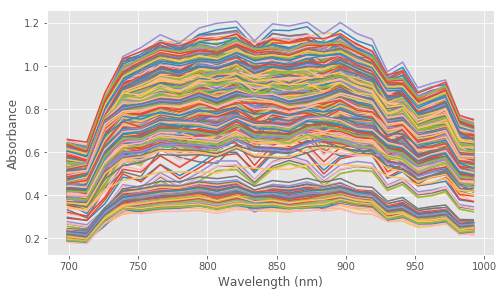

In [22]:
Y_calib = pd.DataFrame.as_matrix(data.iloc[:split, 25])
Y_valid = pd.DataFrame.as_matrix(data.iloc[split:, 25])

# Get spectra
X_calib = pd.DataFrame.as_matrix(data.iloc[:split, :25])
X_valid = pd.DataFrame.as_matrix(data.iloc[split:, :25])

# Get wavelengths 
wl = [699,713,726,739,752,766,780,794,807,821,834,847,859,872,884,896,908,919,930,941,952,962,972,982,992]
    
# Plot spectra
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X_calib.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')    
plt.show()

In [23]:
print(X_valid.shape, Y_valid.shape )


(380, 25) (380,)
(380, 25) (380,)


In [24]:

# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = data.shape[0] #256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 25 #784 # MNIST data input (img shape: 28*28)
num_output = 1

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])
y_true = tf.placeholder("float", [None, num_output])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_output])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_output])),
}


In [25]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
# def decoder(x):
#     # Decoder Hidden layer with sigmoid activation #1
#     layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
#                                    biases['decoder_b1']))
#     # Decoder Hidden layer with sigmoid activation #2
#     layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
#                                    biases['decoder_b2']))
#     return layer_2

# Neural net
# def nn(x):
#     # Decoder Hidden layer with sigmoid activation #1
#     layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder_h1']),
#                                    biases['decoder_b1']))
#     # Decoder Hidden layer with sigmoid activation #2
#     layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
#                                    biases['decoder_b2']))
#     return layer_2

def nn(x):
    # neural network layers
    l1 = tf.layers.dense(x, 80, tf.nn.relu)          # hidden layer
    output = tf.layers.dense(l1, num_output) 
    return output

# Construct model
encoder_op = encoder(X)
#decoder_op = decoder(encoder_op)
decoder_op = nn(encoder_op)

# Prediction
y_pred = decoder_op

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [26]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle).reshape(len(labels_shuffle),1)


In [27]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
batch_x, batch_y = [], []
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, batch_y = next_batch(batch_size, X_calib, Y_calib)
    
    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x, y_true: batch_y})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
    

Step 1: Minibatch Loss: 14.766393
Step 1: Minibatch Loss: 14.766393
Step 1000: Minibatch Loss: 0.428611
Step 1000: Minibatch Loss: 0.428611
Step 2000: Minibatch Loss: 0.314215
Step 2000: Minibatch Loss: 0.314215
Step 3000: Minibatch Loss: 0.353564
Step 3000: Minibatch Loss: 0.353564
Step 4000: Minibatch Loss: 0.539719
Step 4000: Minibatch Loss: 0.539719
Step 5000: Minibatch Loss: 0.251145
Step 5000: Minibatch Loss: 0.251145
Step 6000: Minibatch Loss: 0.130286
Step 6000: Minibatch Loss: 0.130286
Step 7000: Minibatch Loss: 0.176203
Step 7000: Minibatch Loss: 0.176203
Step 8000: Minibatch Loss: 0.329267
Step 8000: Minibatch Loss: 0.329267
Step 9000: Minibatch Loss: 0.116133
Step 9000: Minibatch Loss: 0.116133
Step 10000: Minibatch Loss: 0.184914
Step 10000: Minibatch Loss: 0.184914
Step 11000: Minibatch Loss: 0.235772
Step 11000: Minibatch Loss: 0.235772
Step 12000: Minibatch Loss: 0.583394
Step 12000: Minibatch Loss: 0.583394
Step 13000: Minibatch Loss: 0.100269
Step 13000: Minibatch Los

In [35]:
# Testing
from sklearn.metrics import mean_squared_error
from math import sqrt

# Encode and decode images from test set and visualize their reconstruction.
print("#test data: ", len(Y_valid))
#n = 10
#for i in range(n):
# MNIST test set
batch_x, batch_y = next_batch(len(Y_valid), X_valid, Y_valid)
#batch_x, batch_y = X_valid, np.asarray(Y_valid).reshape(len(Y_valid),1)
# Encode and decode the digit image
y_pred = sess.run(decoder_op, feed_dict={X: batch_x, y_true: batch_y})
print("mean_squared_error:", mean_squared_error(batch_y,y_pred))  
#    for j in range(n):
#       print(pow(batch_y - y_pred, 2))  
        

# print("Reconstructed Images")
# plt.figure(figsize=(n, n))
# plt.imshow(canvas_recon, origin="upper", cmap="gray")
# plt.show()

#test data:  380
mean_squared_error: 0.44382435704692724
